In [4]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constrained Optimization



In [16]:
# Import Data 
sp_returns = pd.read_excel("spx_returns_weekly.xlsx", sheet_name=2, index_col = 0)
etf_returns = pd.read_excel("spx_returns_weekly.xlsx", sheet_name=3, index_col = 0)

# Filter Relevant Data
ticks  =  ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY']
tick_etf = 'SPY'
data = pd.concat([sp_returns[ticks], etf_returns[tick_etf]], axis=1)
data.head()

# Data Covariance
cov = data.cov() * 52



## 1. Constrained Optimization for Mean-Variance

In [ ]:
from scipy.optimize import minimize

# Carry out Constrained Optimization Bounded
def constrained_weights_bound(data: pd.DataFrame, target_mean: float, max_weight: float, min_weight: float, freq: int) -> pd.DataFrame:
    
    mean = data.mean() * freq
    cov_mat = data.cov() * freq
    bounds = [(min_weight, max_weight)] * len(data.columns)

    # Objective Function: Minimize Portfolio Variabce
    def objective_function(w):
        return w.T @ cov_mat @ w

    # Constraint 1: Sum of Weights = 1
    def constraint_capital(w):
        return np.sum(w) - 1

    capital_constraint = {'type': 'eq', 'fun': constraint_capital}

    # Constraint 2: Portfolio Mean = Target Mean
    def constraint_mean(w):
        return (w @ mean) - target_mean

    mean_constraint = {'type': 'eq', 'fun': constraint_mean}

    # All Constraints
    constraints = [capital_constraint, mean_constraint]

    # Initial Input 
    w0 = np.ones(len(data.columns)) / len(data.columns)

    # Conduct Minimization
    result = minimize(
        objective_function, 
        w0, 
        bounds=bounds,
        constraints=constraints
    )

    # Return Weights
    return result.x

# Carry out Constrained Optimization 
def constrained_weights(data: pd.DataFrame, target_mean: float, freq: int) -> pd.DataFrame:
    
    mean = data.mean() * freq
    cov_mat = data.cov() * freq

    # Objective Function: Minimize Portfolio Variabce
    def objective_function(w):
        return w.T @ cov_mat @ w

    # Constraint 1: Sum of Weights = 1
    def constraint_capital(w):
        return np.sum(w) - 1

    capital_constraint = {'type': 'eq', 'fun': constraint_capital}

    # Constraint 2: Portfolio Mean = Target Mean
    def constraint_mean(w):
        return (w @ mean) - target_mean

    mean_constraint = {'type': 'eq', 'fun': constraint_mean}

    # All Constraints
    constraints = [capital_constraint, mean_constraint]

    # Initial Input 
    w0 = np.ones(len(data.columns)) / len(data.columns)

    # Conduct Minimization
    result = minimize(
        objective_function, 
        w0, 
        constraints=constraints
    )

    # Return Weights
    return result.x



In [28]:
# Conduct Optimization: Bounded
w_opt_bounded = constrained_weights_bound(data, 0.2, 0.35, -0.2, 52)

# Portfolio Mean
port_mean_bound = (data.mean() * 52) @ w_opt
# Portfolio Volatility
port_vol_bound = np.sqrt(w_opt.T @ cov @ w_opt)
# Portfolio Sharpe
port_sharpe_bound= port_mean_bound/port_vol_bound


weights_table_bounded = pd.DataFrame({
    'Ticker': data.columns,
    'Weight': w_opt
})

print("Optimized weights:\n", weights_table_bounded)
print(f"Portfolio mean: {port_mean_bound:.2%}")
print(f"Portfolio volatility: {port_vol_bound:.2%}")
print(f"Portfolio Sharpe ratio: {port_sharpe_bound:.2f}")



Optimized weights:
    Ticker    Weight
0    AAPL  0.029241
1    NVDA -0.014344
2    MSFT  0.144508
3   GOOGL  0.009064
4    AMZN  0.093858
5    META  0.002874
6    TSLA -0.015071
7    AVGO  0.036250
8   BRK/B  0.350000
9     LLY  0.213085
10    SPY  0.150535
Portfolio mean: 20.00%
Portfolio volatility: 16.49%
Portfolio Sharpe ratio: 1.21


In [ ]:
# Conduct Optimization: Unounded
w_opt_unbounded = constrained_weights(data, 0.2, 52)

port_mean_unbound = (data.mean() * 52) @ w_opt_unbounded
port_vol_unbound = np.sqrt(w_opt_unbounded.T @ cov_mat @ w_opt_unbounded)
port_sharpe_unbound = port_mean_unbound / port_vol_unbound



weights_table_unbounded = pd.DataFrame({
    'Ticker': data.columns,
    'Weight': w_opt
})

print("Optimized weights:\n", weights_table_unbounded)
print(f"Portfolio mean: {port_mean_unbound:.2%}")
print(f"Portfolio volatility: {port_vol_unbound:.2%}")
print(f"Portfolio Sharpe ratio: {port_sharpe_unbound:.2f}")


Optimized weights:
    Ticker    Weight
0    AAPL  0.029241
1    NVDA -0.014344
2    MSFT  0.144508
3   GOOGL  0.009064
4    AMZN  0.093858
5    META  0.002874
6    TSLA -0.015071
7    AVGO  0.036250
8   BRK/B  0.350000
9     LLY  0.213085
10    SPY  0.150535
Portfolio mean: 20.00%
Portfolio volatility: 16.49%
Portfolio Sharpe ratio: 1.21


In [ ]:
# Analytic Method
mean_ann = data.mean() * 52
cov_mat = data.cov() * 52

w_analytic = np.linalg.inv(cov_mat) @ mean_ann
w_analytic /= np.sum(w_analytic)  # normalize to sum = 1
w_analytic = w_analytic * 0.2 /(w_analytic @ mean_ann)

w_analytic @ mean_ann


np.float64(0.20000000000000007)

In [ ]:
# Equal Weight
n_assets = len(data.columns)
equal_weights = np.ones(n_assets) / n_assets


In [62]:
summary_table = pd.DataFrame({
    'equal': equal_weights,
    'bounded': w_opt_bounded,
    'unbounded': w_opt_unbounded,
    'analytic': w_analytic,
    'mean return': data.mean() * 52,
    'sharpe': (data.mean() * 52) / (data.std() * (52 ** 0.5))
}, index=data.columns)

corr = summary_table['bounded'].corr(summary_table['unbounded'])

# Format as percentages
summary_table_styled = summary_table.style.format('{:.2%}')
summary_table_styled


,equal,bounded,unbounded,analytic,mean return,sharpe
AAPL,9.09%,2.92%,2.95%,6.29%,23.87%,86.29%
NVDA,9.09%,-1.43%,-1.53%,13.56%,64.56%,139.35%
MSFT,9.09%,14.45%,15.20%,13.03%,26.14%,108.93%
GOOGL,9.09%,0.91%,0.82%,2.97%,21.68%,77.47%
AMZN,9.09%,9.39%,9.49%,6.55%,29.34%,95.90%
META,9.09%,0.29%,0.20%,4.26%,26.19%,74.55%
TSLA,9.09%,-1.51%,-1.49%,4.76%,46.98%,80.10%
AVGO,9.09%,3.62%,3.54%,9.24%,39.49%,105.26%
BRK/B,9.09%,35.00%,36.76%,39.63%,13.50%,70.82%
LLY,9.09%,21.31%,21.05%,17.09%,28.15%,99.49%


The most extreme positions in the bounded portfolio do not always correspond to the assets with the highest Sharpe ratios or mean returns. This is because the optimizer is constrained by bounds and a fixed target mean. It balances expected return against risk and cannot fully allocate to high-Sharpe assets.

In [63]:
print(f"The correlation between BOUNDED and UNBOUNDED is: {corr} %")

The correlation between BOUNDED and UNBOUNDED is: 0.9975332859405379 %


In [64]:
# Compute portfolio stats 
def portfolio_stats(weights, mean, cov):
    port_mean = weights @ mean
    port_vol = np.sqrt(weights.T @ cov @ weights)
    port_sharpe = port_mean / port_vol
    return port_mean, port_vol, port_sharpe

stats = {}
for name, w in zip(
    ['equal', 'bounded', 'unbounded', 'analytic'],
    [equal_weights, w_opt_bounded, w_opt_unbounded, w_analytic]
):
    m, v, s = portfolio_stats(w, mean_ann, cov_mat)
    stats[name] = [m, v, s]

# --- Build DataFrame ---
stats_table = pd.DataFrame(stats, index=['mean', 'vol', 'sharpe']).T

# Format as percentages
stats_table = stats_table.style.format({
    'mean': '{:.2%}',
    'vol': '{:.2%}',
    'sharpe': '{:.2%}'
})

stats_table

,mean,vol,sharpe
equal,30.28%,22.16%,136.64%
bounded,20.00%,16.49%,121.29%
unbounded,20.00%,16.49%,121.31%
analytic,20.00%,9.67%,206.85%


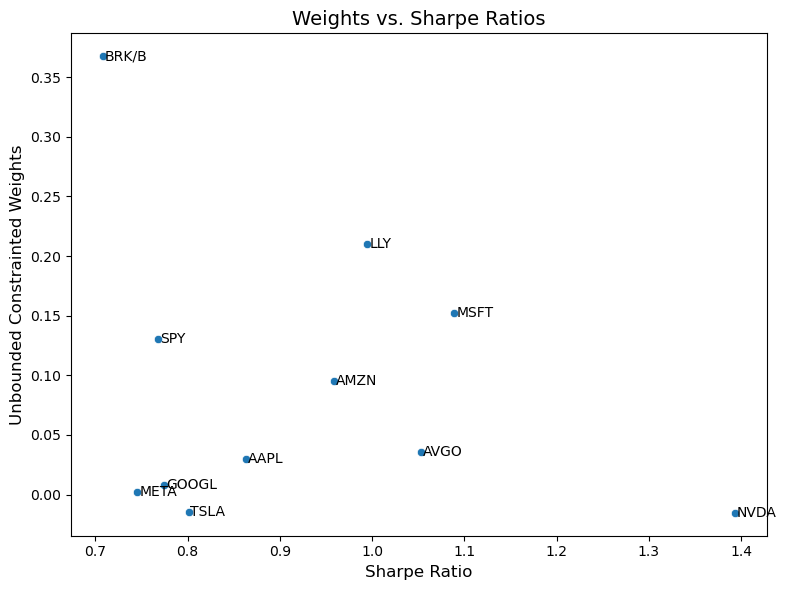

In [66]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="sharpe", y="unbounded", data=summary_table)
for i in range(len(summary_table)):
    plt.text(summary_table["sharpe"].iloc[i] + 0.002,
             summary_table["unbounded"].iloc[i], 
             summary_table.index[i],
             fontsize=10, ha='left', va='center')
plt.title("Weights vs. Sharpe Ratios", fontsize=14)
plt.xlabel("Sharpe Ratio", fontsize=12)
plt.ylabel("Unbounded Constrainted Weights", fontsize=12)
plt.tight_layout()
plt.show()